In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from scipy.io.matlab.mio import loadmat, savemat
import numpy as np
from PIL import Image
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch import nn, optim
import shutil
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn import preprocessing


C:\Users\xia\AppData\Local\Temp\ipykernel_15052\1157685092.py:8: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
C:\Users\xia\AppData\Local\Temp\ipykernel_15052\1157685092.py:8: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


In [94]:
def getData(filename1,filename2, remove_duplicata = True):
    df1 = pd.read_csv(filename1)
    df1.drop(df1.columns[len(df1.columns)-1], axis=1,inplace = True)
    df2 = pd.read_csv(filename2)
    X1 = df1.to_numpy()
    X2 = df2.to_numpy()
    s1, s2 = X1.shape[1], X2.shape[1]
    X11, X12 = X1[:,s1//2:], X1[:,:s1//2]
    X21, X22 = X2[:,s1//2:], X2[:,:s1//2]
    X = np.hstack((X11,X21,X12,X22))
    return X[:,:-1], X[:,-1]

In [95]:
def extractdata(filename, remove_duplicata = True):
    with open(filename) as f:
        df = pd.read_csv(f)
        if remove_duplicata:
            df = df.drop_duplicates()
        X = df.to_numpy()
    return X[:,:-1], X[:,-1]


In [96]:
X,Y = extractdata("dataBow.csv")
X=X.astype("int64")
X=np.unique(X,axis=0,return_index=True)
X,index = X
Y = Y[index]

In [97]:
print(Y)

['copyPaste' 'replace' 'deleteWord' ... 'replace' 'copyPaste' 'deleteWord']


In [98]:
X.shape

(28617, 5760)

In [99]:

le = preprocessing.LabelEncoder()
newX = normalize(X)

tmp = X[:,X.shape[1]//2:]
anotherX = X[:,:X.shape[1]//2]-tmp
anotherX = normalize(anotherX)
le.fit(Y)
Ynum = le.transform(Y)

In [100]:
le.classes_

array(['copyPaste', 'deleteWord', 'replace'], dtype=object)

In [101]:
dataset = torch.utils.data.TensorDataset(torch.Tensor(anotherX),torch.Tensor(Ynum).type(torch.LongTensor))

In [102]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [103]:
np.unique(Ynum, return_counts=True)

(array([0, 1, 2]), array([ 9587,  8970, 10060], dtype=int64))

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2880, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [105]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # For BCELoss
        #y = y.unsqueeze(1)
        #y = y.float()
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [106]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # For BCELoss
            #y = y.unsqueeze(1)
            #y = y.float()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # BCELoss
            #pred = (pred > 0.5).long()
            #correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [107]:
epochs = 20

model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


# Create the data loaders for training and validation
train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=500,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=500,
    shuffle=False
)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.099537  [  500/22893]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.444640 

Epoch 2
-------------------------------
loss: 0.435963  [  500/22893]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.141038 

Epoch 3
-------------------------------
loss: 0.136126  [  500/22893]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.075645 

Epoch 4
-------------------------------
loss: 0.047507  [  500/22893]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.069172 

Epoch 5
-------------------------------
loss: 0.023048  [  500/22893]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.065871 

Epoch 6
-------------------------------
loss: 0.027813  [  500/22893]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.074042 

Epoch 7
-------------------------------
loss: 0.017247  [  500/22893]
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.082810 

Epoch 8
-------------------------------
loss: 0.035647  [  500/22893]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.074875 

Epoch 9
----------------

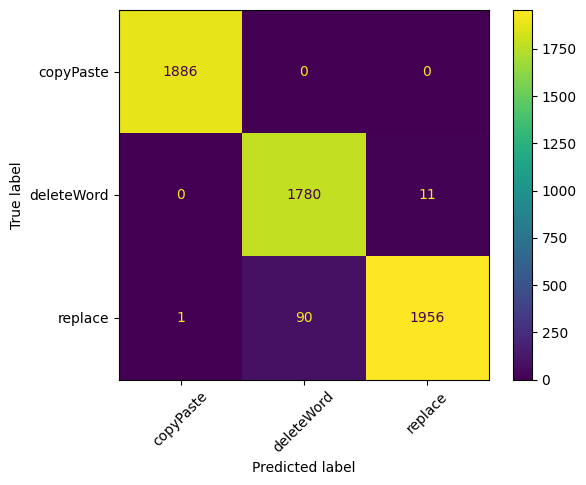

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Used to calculate the confusion matrix
y_true = []
y_pred = []
for X,y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())

    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred.extend(pred.argmax(1).data.cpu().numpy())
    
    #pred = (pred > 0.5).long()
    #y_pred.extend(pred.data.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(Y))
disp.plot()
plt.xticks(rotation=45)
plt.show()


Accuracy avant:  0.9821802935010482
Accuracy après:  0.9909222948438635
pred restantes:  5508
pred supprimees:  216
pourcentage restant:  0.9622641509433962


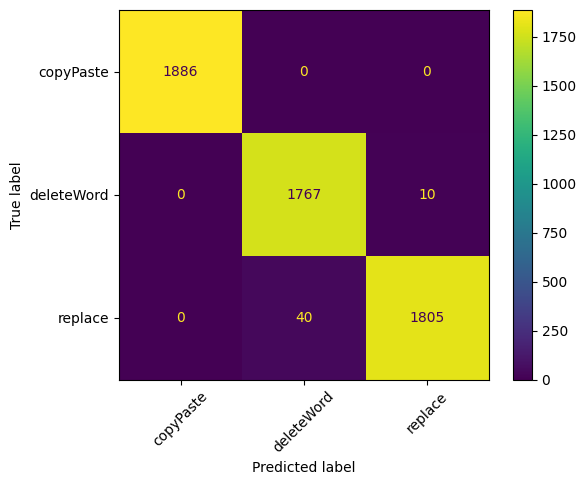

In [110]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.95
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

Accuracy avant:  0.8020735155513666
Accuracy après:  0.9749631811487481
pred restantes:  1358
pred supprimees:  764
pourcentage restant:  0.6399622997172478


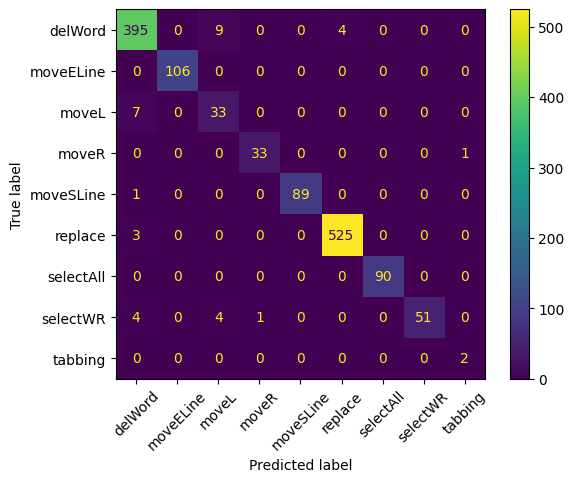

In [43]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in test_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.80
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = le.classes_)
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()

In [111]:
torch.save(model.state_dict(), "./models/bowModelOk")

In [124]:
datatest,labtest = extractdata("handMadeDataTest.csv")
datatest=datatest.astype("int64")
datatest=np.unique(datatest,axis=0,return_index=True)
datatest,index = datatest
labtest = labtest[index]

In [125]:
le = preprocessing.LabelEncoder()
newdatatest = normalize(datatest)

tmp = datatest[:,datatest.shape[1]//2:]
anotherdatatest = datatest[:,:datatest.shape[1]//2]-tmp
anotherdatatest = normalize(anotherdatatest)
le.fit(labtest)
labtestnum = le.transform(labtest)

In [126]:
datatestset = torch.utils.data.TensorDataset(torch.Tensor(anotherdatatest),torch.Tensor(labtestnum).type(torch.LongTensor))

In [127]:
validation_dataloader = torch.utils.data.DataLoader(
    datatestset,
    shuffle=False
)

Accuracy avant:  0.84
Accuracy après:  0.875
pred restantes:  24
pred supprimees:  1
pourcentage restant:  0.96


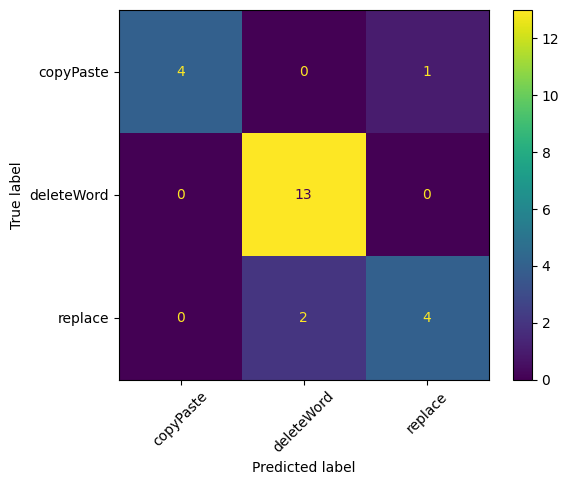

In [128]:

#Used to calculate the confusion matrix
y_true = []
y_pred = []

for X, y in validation_dataloader:
    y_true.extend(y.data.cpu().numpy())
    X, y = X.to(device), y.to(device)
    pred = model(X)
    pred = pred.softmax(dim=1)
    y_pred.extend(pred.data.cpu().numpy())
    
y_pred = np.array(y_pred)
y_true = np.array(y_true)
seuil = 0.95
indices = y_pred.max(1) > seuil

print("Accuracy avant: ", np.where(y_pred.argmax(1) == y_true, 1, 0).mean())
y_pred = y_pred[indices].argmax(1)
y_true = y_true[indices]
print("Accuracy après: ", np.where(y_pred == y_true, 1, 0).mean())

conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = np.unique(Y))
disp.plot()

print("pred restantes: ", sum(indices))
print("pred supprimees: ", sum(False == indices))
print("pourcentage restant: ", sum(indices)/len(indices))
plt.xticks(rotation=45)

plt.show()